Instalación de las librerías necesarias

In [ ]:
!pip install keras-vis

In [ ]:
!pip install pillow

In [ ]:
# Importación de librerías
from PIL import Image  # Biblioteca para manipulación de imágenes

# Redimensionar imágenes
def imresize(image, size):
    """
    Redimensiona la imagen a un tamaño especificado.
    :param image: Imagen PIL a redimensionar.
    :param size: Tupla con el tamaño (ancho, alto) al que redimensionar.
    :return: Imagen redimensionada.
    """
    return image.resize(size, Image.ANTIALIAS)

In [ ]:
# Importación y configuración de librerías para visualización
import vis  # Biblioteca para visualización de redes neuronales
print(vis.__file__)  # Imprime la ruta del archivo del módulo 'vis'

/usr/local/lib/python3.10/dist-packages/vis/__init__.py


In [ ]:
# Configuración inicial

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import os
import pickle

# Configuración de opciones de Pandas

pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

# Importación de librerías de Keras y Visualización

from __future__ import print_function
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.datasets import mnist
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras import backend as K

# Visualización con "vis"

from vis.utils import utils
from keras import activations
from vis.input_modifiers import Jitter


Definición de funciones

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def visualize_activations(model, layer_name, input_image):
    # Crear un modelo que devolverá la salida de la capa específica
    layer_output = model.get_layer(layer_name).output
    activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_output)

    # Obtener la activación
    activations = activation_model.predict(input_image[np.newaxis, ...])

    # Visualizar los filtros de la primera capa de convolución
    num_filters = activations.shape[-1]
    size = activations.shape[1]
    n_cols = 8
    n_rows = num_filters // n_cols

    display_grid = np.zeros((size * n_rows, size * n_cols))

    for col in range(n_cols):
        for row in range(n_rows):
            filter_index = col + n_cols * row
            filter_image = activations[0, :, :, filter_index]
            filter_image -= filter_image.mean()
            filter_image /= filter_image.std() + 1e-5
            filter_image *= 64
            filter_image += 128
            filter_image = np.clip(filter_image, 0, 255).astype('uint8')
            display_grid[row * size : (row + 1) * size, col * size : (col + 1) * size] = filter_image

    scale = 1.0 / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(f'Activations in layer: {layer_name}')
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.show()

In [ ]:
def get_num_filters(layer):
    """
    Obtiene el número de filtros de una capa de convolución.
    :param layer: Capa de convolución.
    :return: Número de filtros.
    """
    return layer.filters

In [ ]:
def smooth_curve(points, factor=0.8):
    smoothed = []
    for point in points:
        if smoothed:
            previous = smoothed[-1]
            smoothed.append(previous * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

def plot_compare(history, steps=-1):
    if steps < 0:
        steps = len(history.history['acc'])
    acc = smooth_curve(history.history['acc'][:steps])
    val_acc = smooth_curve(history.history['val_acc'][:steps])
    loss = smooth_curve(history.history['loss'][:steps])
    val_loss = smooth_curve(history.history['val_loss'][:steps])

    plt.figure(figsize=(6, 4))
    plt.plot(loss, c='#0c7cba', label='Train Loss')
    plt.plot(val_loss, c='#0f9d58', label='Val Loss')
    plt.xticks(range(0, len(loss), 5))
    plt.xlim(0, len(loss))
    plt.title('Train Loss: %.3f, Val Loss: %.3f' % (loss[-1], val_loss[-1]), fontsize=12)
    plt.legend()

    plt.figure(figsize=(6, 4))
    plt.plot(acc, c='#0c7cba', label='Train Acc')
    plt.plot(val_acc, c='#0f9d58', label='Val Acc')
    plt.xticks(range(0, len(acc), 5))
    plt.xlim(0, len(acc))
    plt.title('Train Accuracy: %.3f, Val Accuracy: %.3f' % (acc[-1], val_acc[-1]), fontsize=12)
    plt.legend()

def deprocess_image(x):
    # normalizar tensor: centrar en 0., asegurar que std es 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip a [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convertir en matriz RGB
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def save_history(history, fn):
    with open(fn, 'wb') as fw:
        pickle.dump(history.history, fw, protocol=2)

def load_history(fn):
    class Temp():
        pass
    history = Temp()
    with open(fn, 'rb') as fr:
        history.history = pickle.load(fr)
    return history

def jitter(img, amount=32):
    ox, oy = np.random.randint(-amount, amount+1, 2)
    return np.roll(np.roll(img, ox, -1), oy, -2), ox, oy

def reverse_jitter(img, ox, oy):
    return np.roll(np.roll(img, -ox, -1), -oy, -2)

def plot_image(img):
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')

Construcción de una red neuronal

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1',
                 input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2), name='maxpool_1'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2'))
model.add(MaxPooling2D((2, 2), name='maxpool_2'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3'))
model.add(MaxPooling2D((2, 2), name='maxpool_3'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_4'))
model.add(MaxPooling2D((2, 2), name='maxpool_4'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', name='dense_1'))
model.add(Dense(256, activation='relu', name='dense_2'))
model.add(Dense(1, activation='sigmoid', name='output'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Montaje de Google Drive en Google Colab para acceder a los archivos
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Lista el contenido de la carpeta principal para verificar si se encuentra allí
base_dir = '/content/drive/MyDrive/dogvscat_small'
print("Base directory exists:", os.path.exists(base_dir))
print("Contents of base directory:", os.listdir(base_dir))

# Lista el contenido de las carpetas train, validation, and test
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

print("Train directory exists:", os.path.exists(train_dir))
print("Validation directory exists:", os.path.exists(validation_dir))
print("Test directory exists:", os.path.exists(test_dir))

if os.path.exists(train_dir):
    print("Contents of train directory:", os.listdir(train_dir))
if os.path.exists(validation_dir):
    print("Contents of validation directory:", os.listdir(validation_dir))
if os.path.exists(test_dir):
    print("Contents of test directory:", os.listdir(test_dir))


Base directory exists: True
Contents of base directory: ['validation', 'train', 'test']
Train directory exists: True
Validation directory exists: True
Test directory exists: True
Contents of train directory: ['dogs', 'cats']
Contents of validation directory: ['cats', 'dogs']
Contents of test directory: ['cats', 'dogs']


In [ ]:
# Definir el directorio base donde se encuentran los datos
base_dir = '/content/drive/MyDrive/dogvscat_small'

# Definir las rutas para los directorios de entrenamiento, validación y prueba
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Crear un generador de datos para el conjunto de entrenamiento, que normaliza las imágenes a un rango [0, 1]
train_datagen = ImageDataGenerator(rescale=1./255)

# Crear un generador de datos para el conjunto de validación, que también normaliza las imágenes a un rango [0, 1]
test_datagen = ImageDataGenerator(rescale=1./255)

# Crear un generador que lee imágenes del directorio de entrenamiento
train_generator = train_datagen.flow_from_directory(
        train_dir,                  # Ruta del directorio de entrenamiento
        target_size=(150, 150),     # Tamaño al que se redimensionarán las imágenes
        batch_size=20,              # Número de imágenes en cada lote
        class_mode='binary')        # Tipo de etiqueta (binaria en este caso)

# Crear un generador que lee imágenes del directorio de validación
validation_generator = test_datagen.flow_from_directory(
        validation_dir,             # Ruta del directorio de validación
        target_size=(150, 150),     # Tamaño al que se redimensionarán las imágenes
        batch_size=20,              # Número de imágenes en cada lote
        class_mode='binary')        # Tipo de etiqueta (binaria en este caso)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
# Compilar el modelo si aún no lo has hecho
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Calcular los pasos por época
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size + 1

# Entrena el modelo
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=20,
                    validation_data=validation_generator,
                    validation_steps=validation_steps,
                    verbose=1)

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.5200 - loss: 0.6898 - val_accuracy: 0.4380 - val_loss: 0.6939
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 192ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4380 - val_loss: 0.6939
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.5443 - loss: 0.6759 - val_accuracy: 0.5480 - val_loss: 0.6791
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 199ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5480 - val_loss: 0.6791
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.5993 - loss: 0.6603 - val_accuracy: 0.5270 - val_loss: 0.7190
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 205ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5270 - val_loss: 0.7190
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.5166 - loss: 0.6943 - val_accuracy: 0.5660 - val_loss: 0.6576
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 189ms/step - accuracy: 

In [ ]:
# Guarda el modelo entrenado en un archivo con el nombre 'model.h5'
model.save('model.h5')

# Guarda el historial del entrenamiento en un archivo binario con el nombre 'history.bin'
save_history(history, 'history.bin')

In [ ]:
def plot_compare(history, steps=-1):
    if steps < 0:
        steps = len(history.history['accuracy'])  # Cambiar 'acc' por 'accuracy'

    acc = smooth_curve(history.history['accuracy'][:steps])  # Cambiar 'acc' por 'accuracy'
    val_acc = smooth_curve(history.history['val_accuracy'][:steps])  # Cambiar 'val_acc' por 'val_accuracy'

    loss = smooth_curve(history.history['loss'][:steps])
    val_loss = smooth_curve(history.history['val_loss'][:steps])

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 8))

    # Gráfica de precisión
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training acc')
    plt.plot(epochs, val_acc, label='Validation acc')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Gráfica de pérdida
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

Aumento de datos

In [ ]:
model_aug = Sequential()
model_aug.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1',
                 input_shape=(150, 150, 3)))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_1'))
model_aug.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2'))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_2'))
model_aug.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3'))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_3'))
model_aug.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_4'))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_4'))
model_aug.add(Flatten())
model_aug.add(Dropout(0.5))
model_aug.add(Dense(512, activation='relu', name='dense_1'))
model_aug.add(Dense(256, activation='relu', name='dense_2'))
model_aug.add(Dense(1, activation='sigmoid', name='output'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model_aug.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definir los generadores de datos
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

# Entrenamiento del modelo
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

history_aug = model_aug.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,  # Prueba con 10 épocas para empezar
    validation_data=validation_generator,
    validation_steps=validation_steps,
    verbose=1
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 169s 3s/step - accuracy: 0.4879 - loss: 0.6932 - val_accuracy: 0.5010 - val_loss: 0.6931
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 19s 273ms/step - accuracy: 0.4062 - loss: 0.6934 - val_accuracy: 0.3750 - val_loss: 0.6935
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 167s 3s/step - accuracy: 0.5095 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5312 - loss: 0.6928 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 169s 3s/step - accuracy: 0.4837 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6937
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6250 - loss: 0.6861 - val_accuracy: 0.5000 - val_loss: 0.6972
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 167s 3s/step - accuracy: 0.4833 - loss: 0.6974 - val_accuracy: 0.5060 - val_loss: 0.6931
Epoch 8/10
62/62 ━━━━━━━━━━

In [ ]:
# Guardar el modelo y el historial
model_aug.save('model_aug.h5')
save_history(history_aug, 'history_aug.bin')

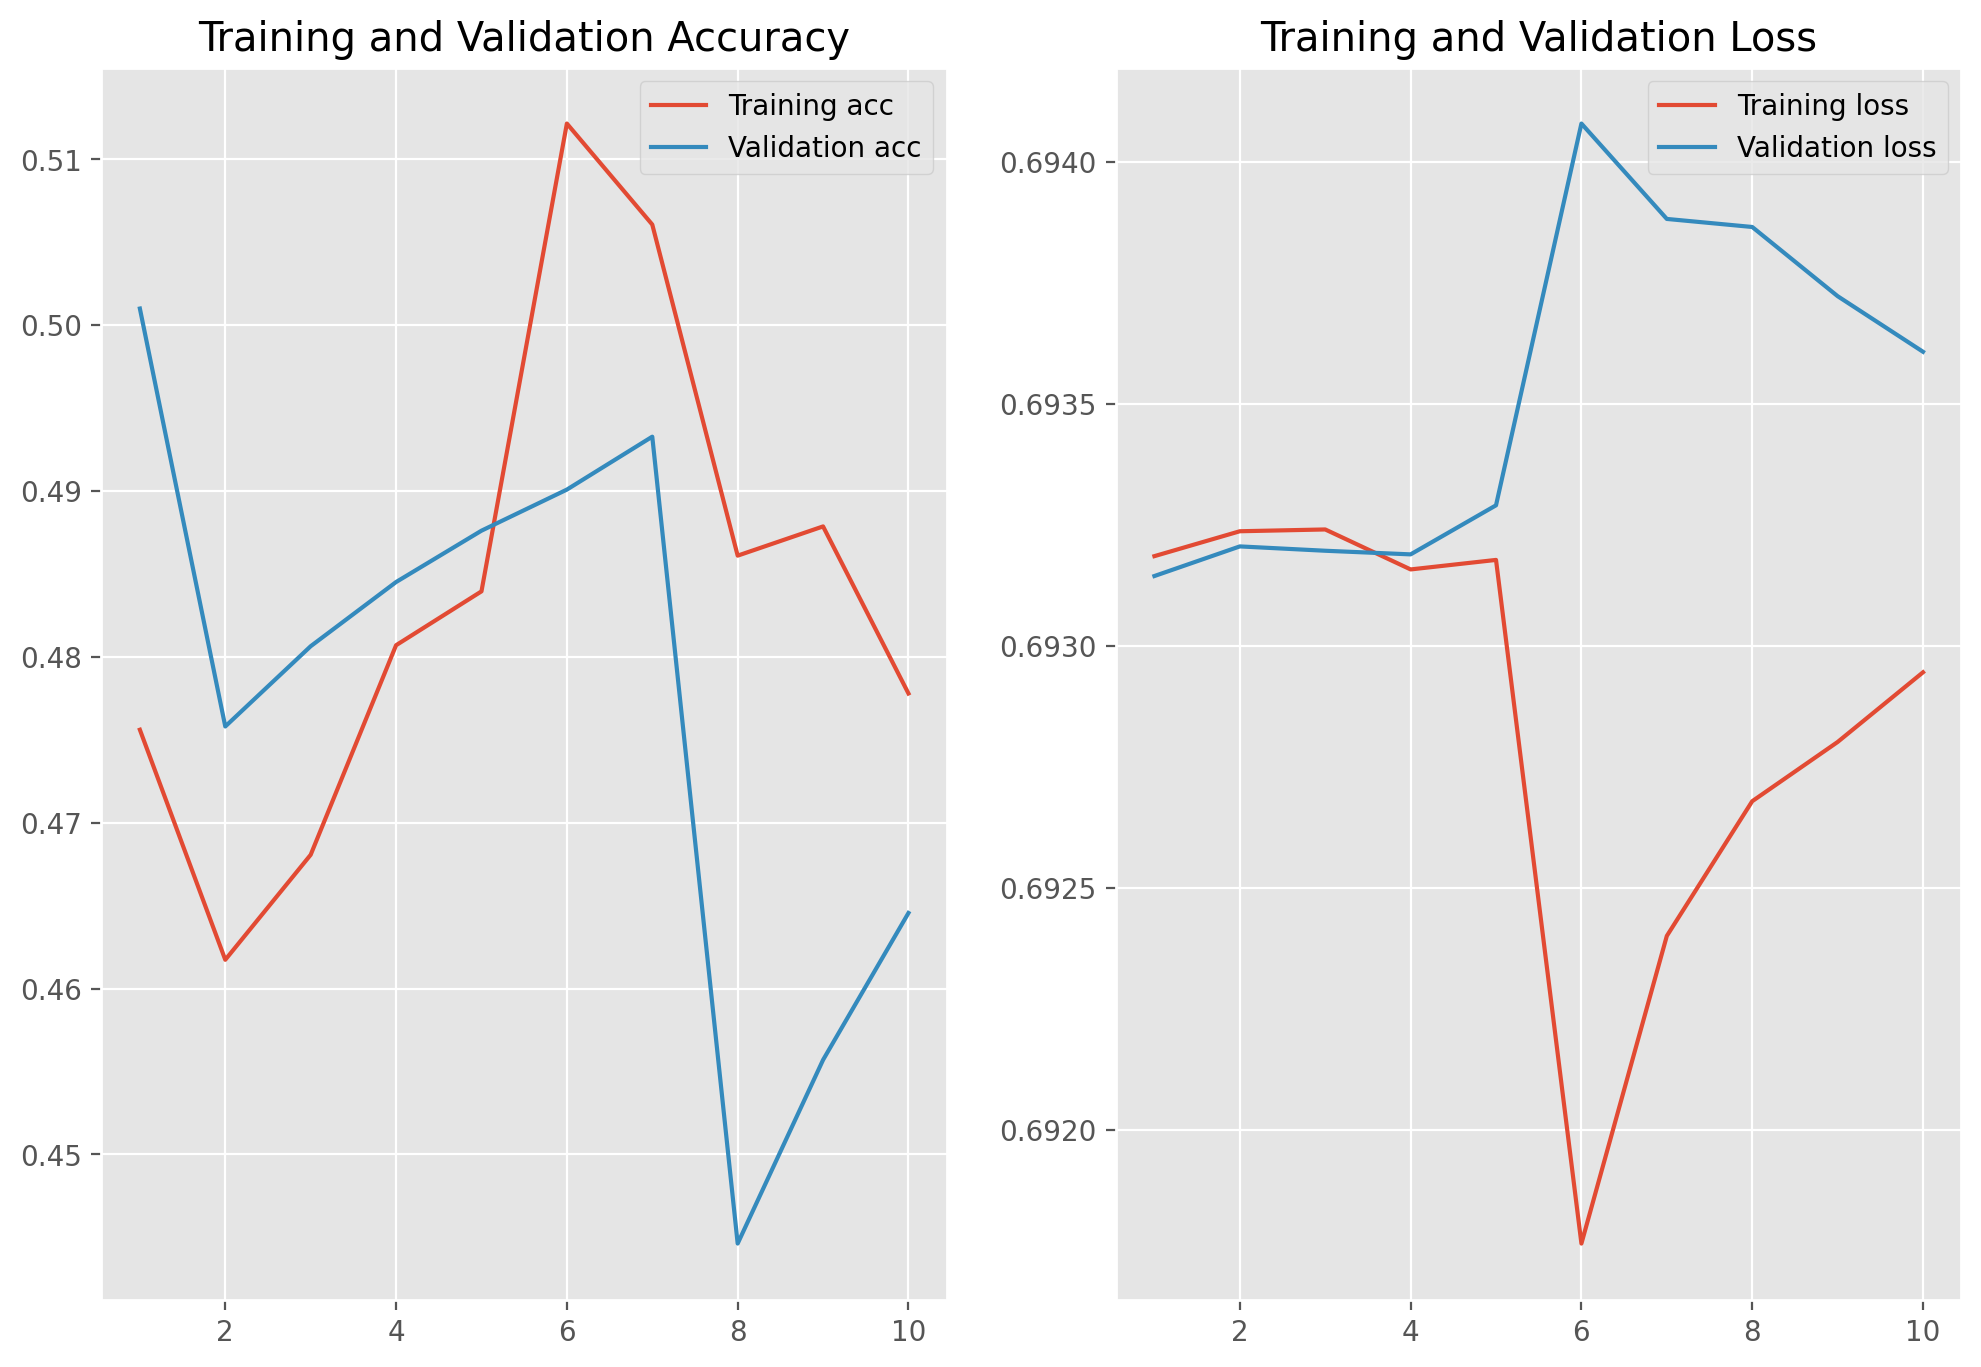

In [ ]:

# Cargar el historial y visualizar el progreso
history_aug = load_history('history_aug.bin')
plot_compare(history_aug, steps=50)

Visualización de mapas de características

In [ ]:
# Cargar y preprocesar una imagen
img_path = '/content/drive/MyDrive/dogvscat_small/train/cats/50.jpg'  # Asegúrate de que la ruta sea correcta

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)

(1, 150, 150, 3)


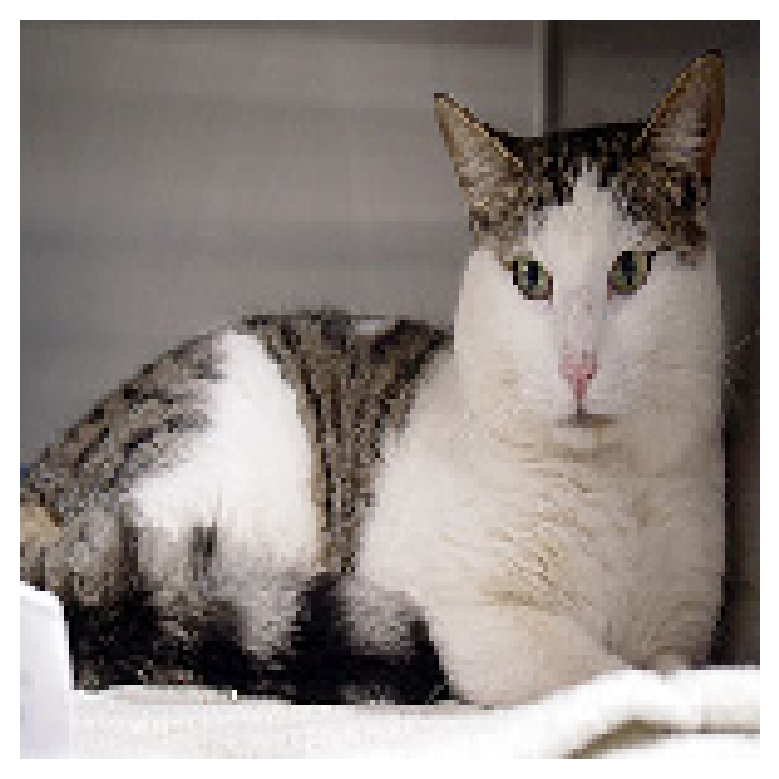

In [ ]:
# Mostrar la imagen
plt.imshow(img_tensor[0])
plt.axis('off')
plt.show()

In [ ]:
# Carga el modelo VGG16 preentrenado con pesos de ImageNet, excluyendo la parte superior (capa de clasificación final)
vgg = VGG16(weights='imagenet', include_top=False)

# Muestra un resumen de la arquitectura del modelo, incluyendo las capas y el número de parámetros
vgg.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


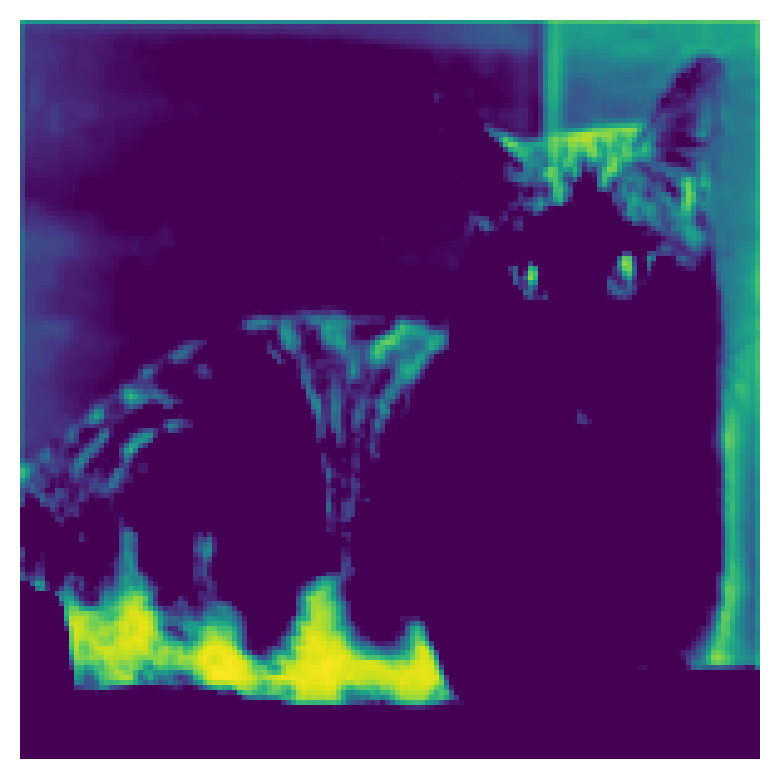

In [ ]:
# Obtiene las salidas de las capas que contienen 'conv1' en su nombre
layer_outputs = [layer.output for layer in vgg.layers if 'conv1' in layer.name]

# Crea un modelo que devolverá las salidas de las capas especificadas
activation_model = Model(inputs=vgg.input, outputs=layer_outputs)

# Calcula las activaciones intermedias para la imagen de entrada
intermediate_activations = activation_model.predict(img_tensor)

# Selecciona la activación de la primera capa (supuesto)
first_layer_activation = intermediate_activations[0]

# Muestra la activación del filtro 19 de la primera capa usando el colormap 'viridis'
plt.imshow(first_layer_activation[0, :, :, 19], cmap='viridis')

# Elimina los ejes de la imagen
plt.axis('off')

# Muestra la imagen
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


<ipython-input-56-4fc3ba436202>:30: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()
<ipython-input-56-4fc3ba436202>:33: RuntimeWarning: invalid value encountered in cast
  channel_image = np.clip(channel_image, 0, 255).astype('uint8')


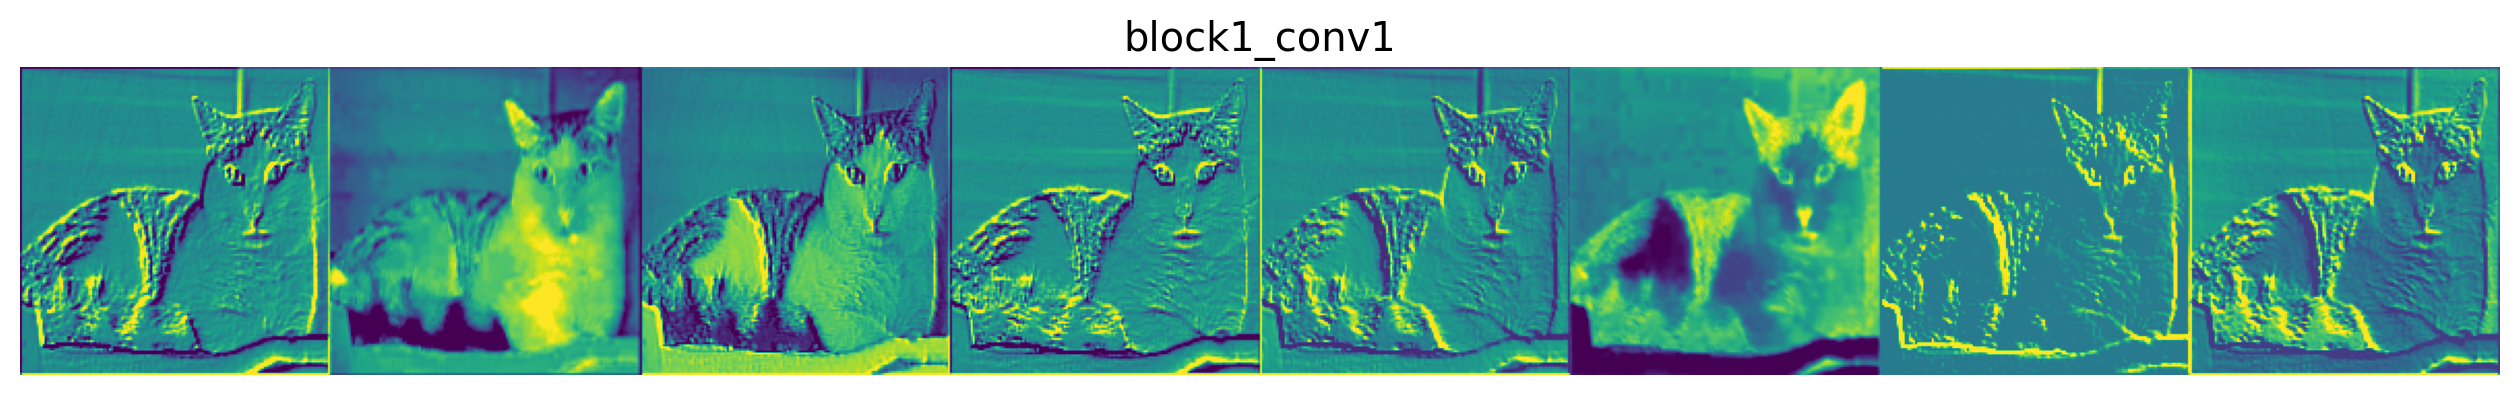

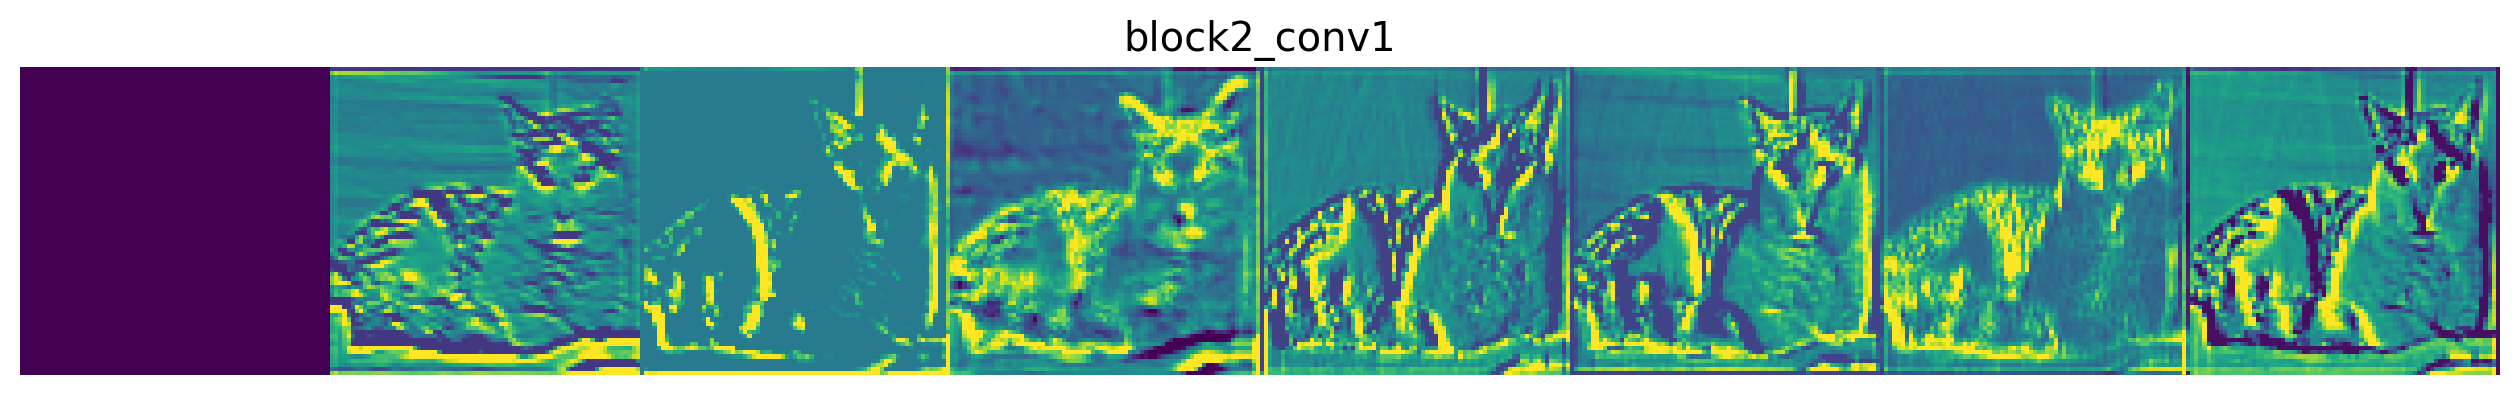

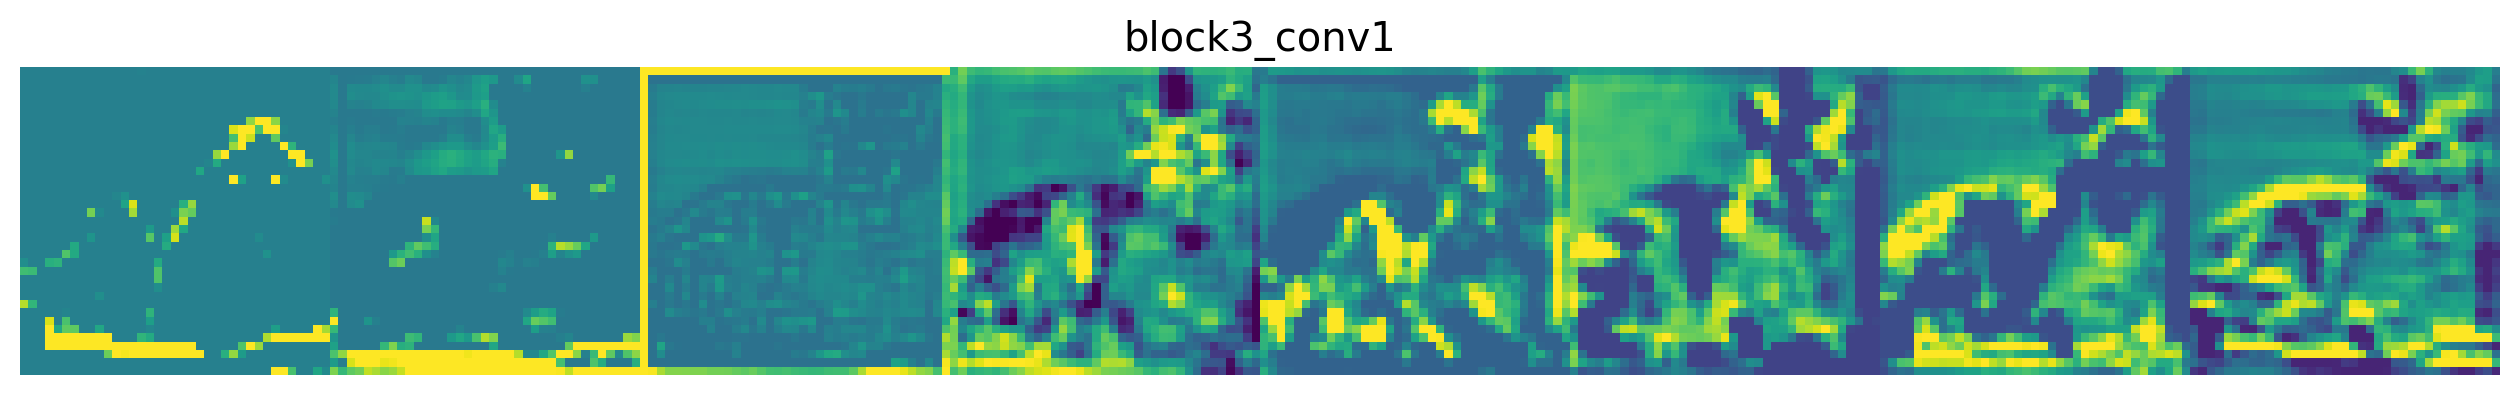

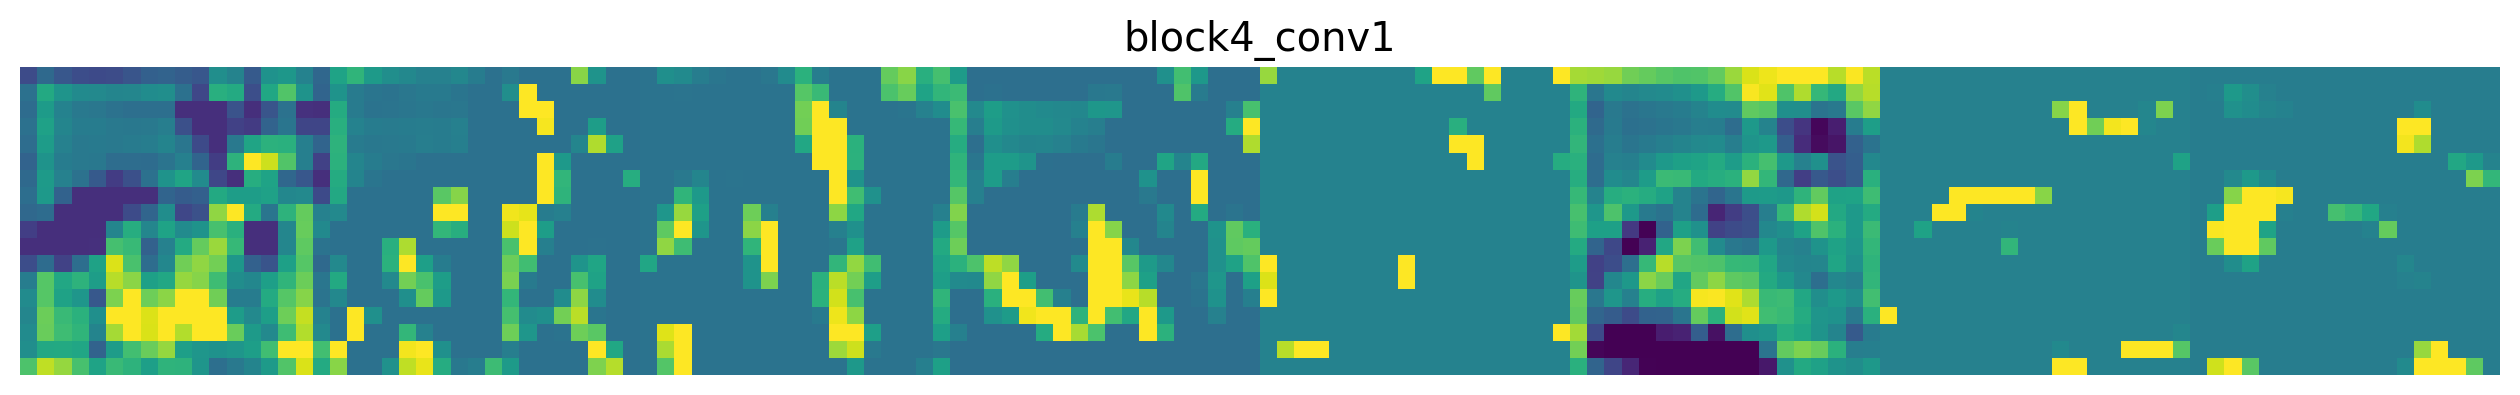

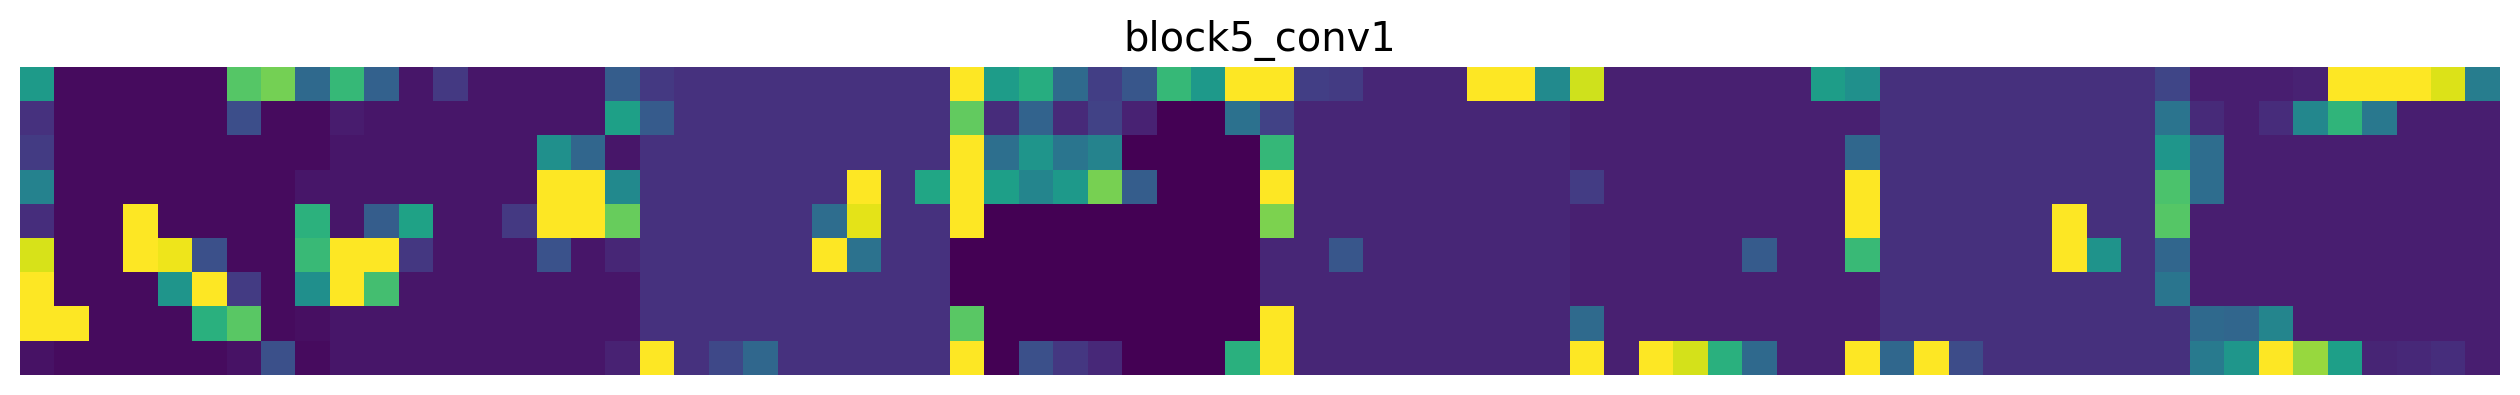

In [ ]:
# Nombres de las capas que vamos a visualizar
layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

# Obtener las salidas de las capas especificadas
layer_outputs = [layer.output for layer in vgg.layers if layer.name in layer_names]

# Crear un modelo que devolverá las salidas de las capas especificadas
activation_model = Model(inputs=vgg.input, outputs=layer_outputs)

# Obtener las activaciones intermedias para una imagen
intermediate_activations = activation_model.predict(img_tensor)

# Configuración para la visualización
images_per_row = 8
max_images = 8

# Ahora vamos a mostrar los mapas de características
for layer_name, layer_activation in zip(layer_names, intermediate_activations):
    # Número de características en el mapa de características
    n_features = layer_activation.shape[-1]
    n_features = min(n_features, max_images)

    # El mapa de características tiene la forma (1, size, size, n_features)
    size = layer_activation.shape[1]

    # Creamos una matriz para colocar los canales de activación
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # Colocamos cada filtro en esta gran cuadrícula horizontal
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-procesamos la característica para hacerla visualmente agradable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Mostrar la cuadrícula
    scale = 2. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.axis('off')
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()
